# Dataset

In [2]:

#from lab 2
def split_set(dataset, key):
        # Sample on minimum amount of party data points
        minimum_amount = min(dataset[key].value_counts())
        print(minimum_amount)
        balanced_set = dataset.groupby(key,
                                        as_index = False,
                                        group_keys=False).apply(lambda s: s.sample(minimum_amount, replace=False))

        print(f'Subset size: {balanced_set.shape[0]}')
        return balanced_set

In [3]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

raw_df = pd.read_csv('GSDatabase.csv')
print(len(raw_df))
df_train, df_test = train_test_split(raw_df, test_size=0.2, stratify=raw_df['3-pt'])
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test['3-pt'])
print(len(df_train))

if True:
    df_train = pd.read_csv('TrainingData.csv').set_index('Index')
    df_val = pd.read_csv('ValidationData.csv').set_index('Index')
    df_test = pd.read_csv('TestData.csv').set_index('Index')

undersampler = RandomUnderSampler()

balanced_set = split_set(df_train, '3-pt')

#balanced_train, blanced_val = train_test_split(balanced_set, test_size=0.2)
x_train = balanced_set['Text'].tolist()
y_train = balanced_set['3-pt'].tolist()
x_val = df_val['Text'].tolist()
y_val = df_val['3-pt'].tolist()
y_test = df_test['3-pt'].tolist()


4953
3962
949
Subset size: 2847


In [4]:
len(df_val)

495

In [5]:
# sanity check
class_0 = balanced_set[balanced_set['3-pt'] == 0]
class_1 = balanced_set[balanced_set['3-pt'] == 1]
class_2 = balanced_set[balanced_set['3-pt'] == 2]
print(len(class_0),len(class_1), len(class_2))

949 949 949


# Analysing data


In [6]:
import matplotlib.pyplot as plt
raw_df.head()

score = sorted(raw_df['Score'].unique())
counts = raw_df['Score'].value_counts().sort_index()
counts3 = raw_df['3-pt'].value_counts().sort_index()
print(counts, counts3)


Score
1.0       13
2.0      150
3.0      232
4.0      791
5.0      819
6.0      621
7.0      766
8.0     1185
9.0      344
10.0      32
Name: count, dtype: int64 3-pt
0    1186
1    1440
2    2327
Name: count, dtype: int64


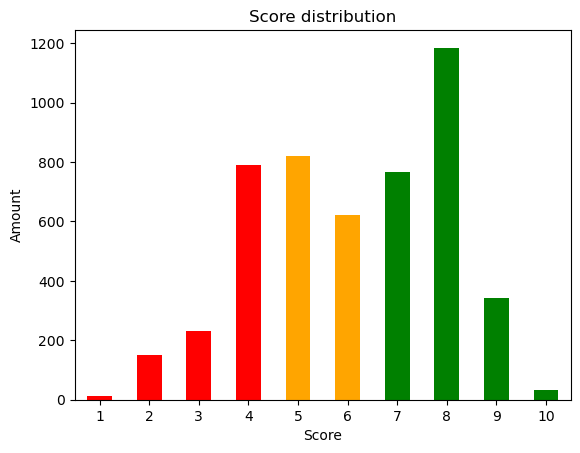

In [7]:
colors = ['red'] * 4 + ['orange'] * 2 + ['green'] * 4
bar_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plot = counts.plot(kind='bar', color=colors)
plot.set_xticklabels(bar_label, rotation=0)
plt.ylabel('Amount')
plt.title('Score distribution')
plt.savefig('figures/scoreDistribution.pdf')


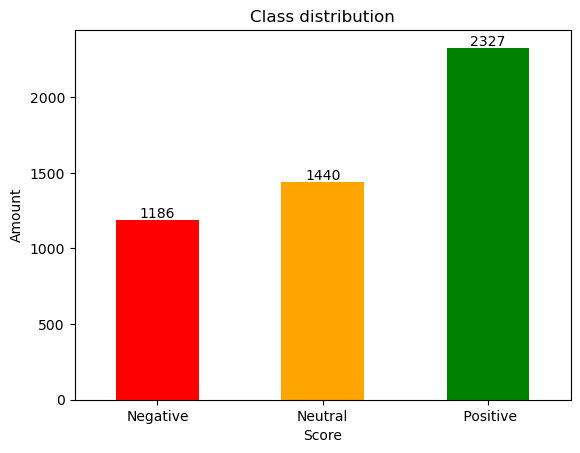

In [8]:
colors = ['red']  + ['orange']  + ['green'] 
bar_label = ['Negative', 'Neutral', ' Positive']
plt.title('Class distribution')

plot = counts3.plot(kind='bar', color=colors)
plt.xlabel('Score')
plt.ylabel('Amount')
plot.set_xticklabels(bar_label, rotation=0)

for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-50),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.savefig('figures/classDistribution.pdf')


In [30]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import random
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)

#analys amount of tokens
length_words = []
lengths_tokens = []

colors = []
for entry in raw_df.itertuples():
    txt = entry.Text
    output = tokenizer(txt)
    length_words.append(len(txt.split()))
    lengths_tokens.append(len(output.tokens()))
    class_ = entry._3
    if class_ == 0:
        color = 'Red'
    elif class_ == 1:
        color = 'Orange'
    elif class_ == 2:
        color = 'Green'
    colors.append(color)

#used used for nicer visulization
test = list(range(len(lengths_tokens)))
random.shuffle(test)


Token indices sequence length is longer than the specified maximum sequence length for this model (2068 > 512). Running this sequence through the model will result in indexing errors


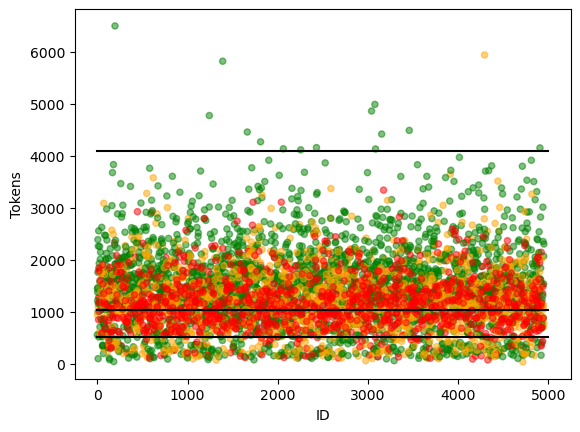

In [41]:
import matplotlib.pyplot as plt

plt.scatter(test, lengths_tokens, color=colors, marker='o', alpha=0.5, s = 20, label='Scatter Points')

plt.plot([0,5000],[512,512], color= 'black')
plt.plot([0,5000],[1024,1024], color= 'black')
plt.plot([0,5000],[4096,4096], color= 'black')
plt.xlabel('ID')
plt.ylabel('Tokens')
plt.title('')
plt.savefig('figures/wordTokenDistribution.pdf')

<BarContainer object of 4 artists>

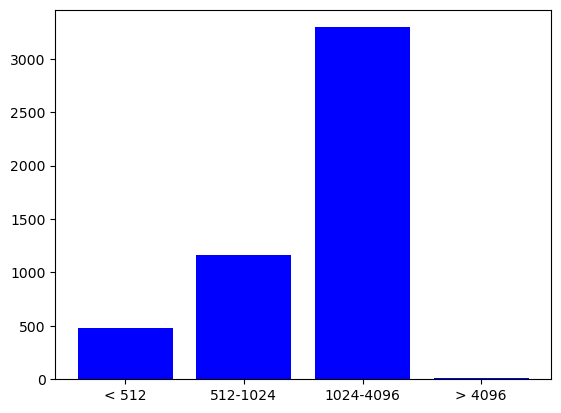

In [39]:
plt.scatter(length_words, lengths_tokens, color=colors, marker='o', alpha=0.5, s = 20, label='Scatter Points')
group_labels = ['< 512', '512-1024', '1024-4096', '> 4096']
groups = [512, 1024, 4096, float('inf')]  # Upper bounds

# Count the occurrences in each group
counts = [0,0,0,0]
for number in lengths_tokens:
    for i,group in enumerate(groups):
        if number < group:
            counts[i] += 1
            break
#counts = [sum(1 for number in lengths_tokens if number < group) for group in groups]

# Create a bar chart
plt.bar(group_labels, counts, color='blue')

In [10]:
test = "This is a test string"
tot = 0
for i, t in enumerate(length_words):
    if t < 500:
        tot +=1
        
print(tot)

711


# Models

In [42]:
# Method of splitting is based on: https://www.youtube.com/watch?v=yDGo9z_RlnE
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def convertTo512(txt, tokenizer, chunksize = 512):
    tokens = tokenizer.encode_plus(txt, return_tensors='pt', padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
    input_id_splits = list(tokens['input_ids'][0].split(510))
    mask_splits = list(tokens['attention_mask'][0].split(510))
    
    for i in range(len(input_id_splits)):
        input_id_splits[i] = torch.cat([
            torch.Tensor([101]), input_id_splits[i], torch.Tensor([102])
        ])
        
        mask_splits[i] = torch.cat([
            torch.Tensor([1]), mask_splits[i], torch.Tensor([1])
        ])
        
        pad = chunksize - input_id_splits[i].shape[0]
        if pad > 0:
            input_id_splits[i] = torch.cat([
                input_id_splits[i], torch.Tensor([0] * pad)
            ])
            
            mask_splits[i] = torch.cat([
                mask_splits[i], torch.Tensor([0] * pad)
            ])
    
    return torch.stack(input_id_splits).to(device), torch.stack(mask_splits).to(device)




In [12]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import numpy as np


class GamespotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:

x_train_tokenize = tokenizer(x_train, max_length=512, padding=True, truncation=True, add_special_tokens = True)
x_val_tokenize = tokenizer(x_val, max_length=512, padding=True, truncation=True, add_special_tokens = True)

train_dataset = GamespotDataset(x_train_tokenize, y_train)

val_dataset = GamespotDataset(x_val_tokenize, y_val)


In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [15]:
args = TrainingArguments(
    output_dir="BERT-finetuned", 
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics 
)

In [16]:
device

device(type='cuda')

In [17]:
torch.cuda.is_available()

True

In [21]:
torch.cuda.empty_cache()
trainer.train()  

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.84330815076828, 'eval_accuracy': 0.5898989898989899, 'eval_precision': 0.6519386481204426, 'eval_recall': 0.5898989898989899, 'eval_f1': 0.5946232430988705, 'eval_runtime': 10.361, 'eval_samples_per_second': 47.775, 'eval_steps_per_second': 5.984, 'epoch': 1.0}
{'loss': 0.8394, 'learning_rate': 1.0636704119850187e-05, 'epoch': 1.4}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.8149619698524475, 'eval_accuracy': 0.6646464646464646, 'eval_precision': 0.7043881332373032, 'eval_recall': 0.6646464646464646, 'eval_f1': 0.6737195643210183, 'eval_runtime': 9.8982, 'eval_samples_per_second': 50.009, 'eval_steps_per_second': 6.264, 'epoch': 2.0}
{'loss': 0.511, 'learning_rate': 1.2734082397003748e-06, 'epoch': 2.81}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.8518240451812744, 'eval_accuracy': 0.6848484848484848, 'eval_precision': 0.7124816110833393, 'eval_recall': 0.6848484848484848, 'eval_f1': 0.6929775976584487, 'eval_runtime': 10.7553, 'eval_samples_per_second': 46.024, 'eval_steps_per_second': 5.765, 'epoch': 3.0}
{'train_runtime': 591.5732, 'train_samples_per_second': 14.438, 'train_steps_per_second': 1.805, 'train_loss': 0.6582497961065742, 'epoch': 3.0}


TrainOutput(global_step=1068, training_loss=0.6582497961065742, metrics={'train_runtime': 591.5732, 'train_samples_per_second': 14.438, 'train_steps_per_second': 1.805, 'train_loss': 0.6582497961065742, 'epoch': 3.0})

In [22]:
trainer.save_model()

In [25]:
def get_prediction_cool(df, model, tokenizer):
    model.to(device)
    preds = []
    for entry in df.itertuples():
        txt = entry.Text
        input_ids, mask = convertTo512(txt, tokenizer)
        input_dict = {
            'input_ids' : input_ids.long(),
            'attention_mask': mask.int()
        }
        output = model(**input_dict)
        probs = F.softmax(output.logits, dim=-1)
        mean = probs.mean(dim=0)
        #print(mean) #0,1,2
        preds.append(torch.argmax(mean).item())
    return preds


In [24]:
def get_prediction(df, model, tokenizer, max_length=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds = []
    for entry in df.itertuples():
        txt = entry.Text
        inputs = tokenizer.encode_plus(txt, return_tensors="pt", max_length=max_length, padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
        inputs.to(device)
        output = model(**inputs)
        probs = F.softmax(output.logits, dim=-1)
        p = torch.argmax(probs).item()
        preds.append(p)
    return preds
        

In [31]:
loaded_model = AutoModelForSequenceClassification.from_pretrained("BERT-finetuned/")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)
loaded_model.to(device)
torch.cuda.empty_cache()
preds = get_prediction(df_test, loaded_model, tokenizer)

In [32]:
torch.cuda.empty_cache()

In [33]:
from sklearn.metrics import classification_report

print(len(preds), len(preds))
print(classification_report(y_test, preds, target_names=['negative','neutral','positive'], digits=3))

496 496
              precision    recall  f1-score   support

    negative      0.580     0.639     0.608       119
     neutral      0.433     0.472     0.452       144
    positive      0.865     0.773     0.816       233

    accuracy                          0.653       496
   macro avg      0.626     0.628     0.625       496
weighted avg      0.671     0.653     0.661       496



In [34]:
preds_n512 = get_prediction_cool(df_test,loaded_model, tokenizer)

In [35]:
print(classification_report(y_test, preds_n512, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.605     0.605     0.605       119
     neutral      0.444     0.521     0.479       144
    positive      0.861     0.768     0.812       233

    accuracy                          0.657       496
   macro avg      0.636     0.631     0.632       496
weighted avg      0.678     0.657     0.666       496



# XLnet

In [22]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, trange
import torch

# Load pre-trained XLNet model and tokenizer
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

texts = x_train
labels = y_train  

tokenized_texts = tokenizer(texts, max_length = 512, padding=True, truncation=True, return_tensors="pt").to(device)

labels = torch.tensor(labels).to(device)

dataset = TensorDataset(tokenized_texts["input_ids"], tokenized_texts["attention_mask"], labels)

batch_size = 12
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up training parameters
epochs = 4
learning_rate = 1e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
for epoch in trange(epochs, desc="Outer Loop"):
    model.train()
    total_loss = 0
    i = 1
    for batch in dataloader:
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        #inputs.to(device)
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(str(i) + '/' + str(len(dataloader)))
        i += 1

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}")

# Save the trained model
model.save_pretrained("xl-finetuned")


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tomas\Anaconda3\envs\py310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Outer Loop:   0%|          | 0/4 [00:00<?, ?it/s]

1/238
2/238
3/238
4/238
5/238
6/238
7/238
8/238
9/238
10/238
11/238
12/238
13/238
14/238
15/238
16/238
17/238
18/238
19/238
20/238
21/238
22/238
23/238
24/238
25/238
26/238
27/238
28/238
29/238
30/238
31/238
32/238
33/238
34/238
35/238
36/238
37/238
38/238
39/238
40/238
41/238
42/238
43/238
44/238
45/238
46/238
47/238
48/238
49/238
50/238
51/238
52/238
53/238
54/238
55/238
56/238
57/238
58/238
59/238
60/238
61/238
62/238
63/238
64/238
65/238
66/238
67/238
68/238
69/238
70/238
71/238
72/238
73/238
74/238
75/238
76/238
77/238
78/238
79/238
80/238
81/238
82/238
83/238
84/238
85/238
86/238
87/238
88/238
89/238
90/238
91/238
92/238
93/238
94/238
95/238
96/238
97/238
98/238
99/238
100/238
101/238
102/238
103/238
104/238
105/238
106/238
107/238
108/238
109/238
110/238
111/238
112/238
113/238
114/238
115/238
116/238
117/238
118/238
119/238
120/238
121/238
122/238
123/238
124/238
125/238
126/238
127/238
128/238
129/238
130/238
131/238
132/238
133/238
134/238
135/238
136/238
137/238
138/238
139/

Outer Loop:  25%|██▌       | 1/4 [05:40<17:02, 340.91s/it]

238/238
Epoch 1/4, Average Loss: 0.9385944093976702
1/238
2/238
3/238
4/238
5/238
6/238
7/238
8/238
9/238
10/238
11/238
12/238
13/238
14/238
15/238
16/238
17/238
18/238
19/238
20/238
21/238
22/238
23/238
24/238
25/238
26/238
27/238
28/238
29/238
30/238
31/238
32/238
33/238
34/238
35/238
36/238
37/238
38/238
39/238
40/238
41/238
42/238
43/238
44/238
45/238
46/238
47/238
48/238
49/238
50/238
51/238
52/238
53/238
54/238
55/238
56/238
57/238
58/238
59/238
60/238
61/238
62/238
63/238
64/238
65/238
66/238
67/238
68/238
69/238
70/238
71/238
72/238
73/238
74/238
75/238
76/238
77/238
78/238
79/238
80/238
81/238
82/238
83/238
84/238
85/238
86/238
87/238
88/238
89/238
90/238
91/238
92/238
93/238
94/238
95/238
96/238
97/238
98/238
99/238
100/238
101/238
102/238
103/238
104/238
105/238
106/238
107/238
108/238
109/238
110/238
111/238
112/238
113/238
114/238
115/238
116/238
117/238
118/238
119/238
120/238
121/238
122/238
123/238
124/238
125/238
126/238
127/238
128/238
129/238
130/238
131/238
132/238


Outer Loop:  50%|█████     | 2/4 [11:25<11:26, 343.10s/it]

238/238
Epoch 2/4, Average Loss: 0.6642122442732338
1/238
2/238
3/238
4/238
5/238
6/238
7/238
8/238
9/238
10/238
11/238
12/238
13/238
14/238
15/238
16/238
17/238
18/238
19/238
20/238
21/238
22/238
23/238
24/238
25/238
26/238
27/238
28/238
29/238
30/238
31/238
32/238
33/238
34/238
35/238
36/238
37/238
38/238
39/238
40/238
41/238
42/238
43/238
44/238
45/238
46/238
47/238
48/238
49/238
50/238
51/238
52/238
53/238
54/238
55/238
56/238
57/238
58/238
59/238
60/238
61/238
62/238
63/238
64/238
65/238
66/238
67/238
68/238
69/238
70/238
71/238
72/238
73/238
74/238
75/238
76/238
77/238
78/238
79/238
80/238
81/238
82/238
83/238
84/238
85/238
86/238
87/238
88/238
89/238
90/238
91/238
92/238
93/238
94/238
95/238
96/238
97/238
98/238
99/238
100/238
101/238
102/238
103/238
104/238
105/238
106/238
107/238
108/238
109/238
110/238
111/238
112/238
113/238
114/238
115/238
116/238
117/238
118/238
119/238
120/238
121/238
122/238
123/238
124/238
125/238
126/238
127/238
128/238
129/238
130/238
131/238
132/238


Outer Loop:  75%|███████▌  | 3/4 [17:21<05:49, 349.17s/it]

238/238
Epoch 3/4, Average Loss: 0.5711222928987831
1/238
2/238
3/238
4/238
5/238
6/238
7/238
8/238
9/238
10/238
11/238
12/238
13/238
14/238
15/238
16/238
17/238
18/238
19/238
20/238
21/238
22/238
23/238
24/238
25/238
26/238
27/238
28/238
29/238
30/238
31/238
32/238
33/238
34/238
35/238
36/238
37/238
38/238
39/238
40/238
41/238
42/238
43/238
44/238
45/238
46/238
47/238
48/238
49/238
50/238
51/238
52/238
53/238
54/238
55/238
56/238
57/238
58/238
59/238
60/238
61/238
62/238
63/238
64/238
65/238
66/238
67/238
68/238
69/238
70/238
71/238
72/238
73/238
74/238
75/238
76/238
77/238
78/238
79/238
80/238
81/238
82/238
83/238
84/238
85/238
86/238
87/238
88/238
89/238
90/238
91/238
92/238
93/238
94/238
95/238
96/238
97/238
98/238
99/238
100/238
101/238
102/238
103/238
104/238
105/238
106/238
107/238
108/238
109/238
110/238
111/238
112/238
113/238
114/238
115/238
116/238
117/238
118/238
119/238
120/238
121/238
122/238
123/238
124/238
125/238
126/238
127/238
128/238
129/238
130/238
131/238
132/238


Outer Loop: 100%|██████████| 4/4 [23:17<00:00, 349.31s/it]

238/238
Epoch 4/4, Average Loss: 0.47520204417470124


In [36]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
loaded_model = AutoModelForSequenceClassification.from_pretrained("xl-finetuned")

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
loaded_model.to(device)

x_test = df_test['Text']
preds_xl = get_prediction(df_test, loaded_model, tokenizer, 512)
    

In [37]:
from sklearn.metrics import classification_report
val_xl = get_prediction(df_val, loaded_model, tokenizer, 512)
print(classification_report(y_val, val_xl, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.724     0.780     0.751       118
     neutral      0.580     0.576     0.578       144
    positive      0.853     0.824     0.838       233

    accuracy                          0.741       495
   macro avg      0.719     0.727     0.723       495
weighted avg      0.743     0.741     0.742       495



In [38]:

print(len(y_test),len(preds_xl))
print(classification_report(y_test, preds_xl, target_names=['negative','neutral','positive'], digits=3))

496 496
              precision    recall  f1-score   support

    negative      0.682     0.756     0.717       119
     neutral      0.612     0.569     0.590       144
    positive      0.883     0.871     0.877       233

    accuracy                          0.756       496
   macro avg      0.725     0.732     0.728       496
weighted avg      0.756     0.756     0.755       496



In [36]:
df_train.to_csv('TrainingData.csv')
df_val.to_csv('ValidationData.csv')
df_test.to_csv('TestData.csv')

# Longformer
Train model

In [18]:
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerTokenizer, LongformerForSequenceClassification

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=3).to(device)

x_train_tokenize = tokenizer(x_train, max_length=1024, padding=True, truncation=True, add_special_tokens = True)
x_val_tokenize = tokenizer(x_val, max_length=1024, padding=True, truncation=True, add_special_tokens = True)

train_dataset = GamespotDataset(x_train_tokenize, y_train)

val_dataset = GamespotDataset(x_val_tokenize, y_val)


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [20]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="longformer-finetuned", 
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics 
)

In [21]:
trainer.train()

  0%|          | 0/2136 [00:00<?, ?it/s]

{'loss': 0.8277, 'learning_rate': 1.5318352059925095e-05, 'epoch': 0.7}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.5052012801170349, 'eval_accuracy': 0.7818181818181819, 'eval_precision': 0.7772877874856291, 'eval_recall': 0.7818181818181819, 'eval_f1': 0.7763887740572656, 'eval_runtime': 41.1495, 'eval_samples_per_second': 12.029, 'eval_steps_per_second': 1.507, 'epoch': 1.0}
{'loss': 0.5865, 'learning_rate': 1.0636704119850187e-05, 'epoch': 1.4}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.7533291578292847, 'eval_accuracy': 0.7555555555555555, 'eval_precision': 0.7661033028011301, 'eval_recall': 0.7555555555555555, 'eval_f1': 0.759325957612089, 'eval_runtime': 41.099, 'eval_samples_per_second': 12.044, 'eval_steps_per_second': 1.509, 'epoch': 2.0}
{'loss': 0.4936, 'learning_rate': 5.955056179775281e-06, 'epoch': 2.11}
{'loss': 0.4242, 'learning_rate': 1.2734082397003748e-06, 'epoch': 2.81}


  0%|          | 0/62 [00:00<?, ?it/s]

{'eval_loss': 0.9534991383552551, 'eval_accuracy': 0.7818181818181819, 'eval_precision': 0.8028956434821125, 'eval_recall': 0.7818181818181819, 'eval_f1': 0.7882523574449356, 'eval_runtime': 41.0968, 'eval_samples_per_second': 12.045, 'eval_steps_per_second': 1.509, 'epoch': 3.0}
{'train_runtime': 3279.8042, 'train_samples_per_second': 2.604, 'train_steps_per_second': 0.651, 'train_loss': 0.567911371309659, 'epoch': 3.0}


TrainOutput(global_step=2136, training_loss=0.567911371309659, metrics={'train_runtime': 3279.8042, 'train_samples_per_second': 2.604, 'train_steps_per_second': 0.651, 'train_loss': 0.567911371309659, 'epoch': 3.0})

In [22]:
trainer.save_model()

In [26]:
longformer_model = AutoModelForSequenceClassification.from_pretrained("longformer-finetuned/")
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model.to(device)
torch.cuda.empty_cache()
longformer_prediction4096 = get_prediction(df_test,longformer_model,longformer_tokenizer,4096)


In [27]:

from sklearn.metrics import classification_report
print(classification_report(y_test, longformer_prediction4096, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.691     0.714     0.702       119
     neutral      0.645     0.681     0.662       144
    positive      0.950     0.901     0.925       233

    accuracy                          0.792       496
   macro avg      0.762     0.765     0.763       496
weighted avg      0.799     0.792     0.795       496



In [28]:
torch.cuda.empty_cache()
longformer_prediction512 = get_prediction(df_test, longformer_model, longformer_tokenizer, 512)
print(classification_report(y_test, longformer_prediction512, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.703     0.597     0.645       119
     neutral      0.554     0.646     0.596       144
    positive      0.877     0.854     0.865       233

    accuracy                          0.732       496
   macro avg      0.711     0.699     0.702       496
weighted avg      0.741     0.732     0.734       496



1 1 1 0
5 2 1 2
8 2 2 1
14 0 2 1
19 1 2 1
22 2 1 2
23 1 2 1
27 2 2 1
28 1 1 0
34 2 2 1
48 1 2 1
49 2 2 1
50 2 2 1
52 0 1 0
56 2 2 1
62 2 0 1
66 2 2 1
67 2 2 1
71 2 2 1
76 1 2 1
82 1 2 0
93 2 2 1
95 1 2 1
96 2 2 1
102 2 1 2
106 1 2 1
108 2 1 2
118 2 2 1
120 2 1 2
121 2 1 2
123 2 1 2
125 2 2 1
133 1 0 1
137 2 2 1
139 1 2 1
140 2 1 2
143 2 2 1
144 2 2 1
154 2 2 1
157 1 2 1
161 1 1 0
162 2 2 1
164 1 1 0
165 2 2 1
166 1 2 1
190 1 2 1
191 2 1 2
198 2 1 2
200 1 1 0
205 1 1 0
209 2 2 1
210 2 2 1
212 2 2 1
214 2 1 2
216 1 2 1
217 2 2 1
219 2 1 2
230 1 2 1
232 2 0 1
239 2 2 1
243 0 0 1
254 2 2 1
255 1 1 0
257 2 1 2
261 1 2 1
268 2 2 1
272 1 1 0
275 1 0 1
278 1 2 1
283 2 2 1
286 2 2 1
287 2 2 1
288 1 2 1
290 2 2 1
293 2 2 1
296 2 1 2
300 1 1 0
304 1 1 0
307 1 2 1
308 2 2 1
313 2 2 1
318 1 1 0
321 2 0 1
322 2 2 1
327 2 2 1
330 1 1 0
335 1 2 1
338 2 2 1
339 2 2 1
340 2 2 0
341 2 2 1
345 2 1 2
347 2 2 1
348 1 2 0
349 1 2 0
364 2 1 2
368 2 2 1
369 1 2 1
370 1 2 1
383 2 1 2
391 2 1 2
403 1 0 1
404 2 0

# Evaluation

In [40]:
# Kolla på några failade och lägg till global attention på dom

df_test, preds, preds_n512, longformer_prediction512, longformer_prediction4096, preds_xl

df_final = df_test

In [42]:
df_final['B512'] = preds
df_final['BN512'] = preds_n512
df_final['L512'] = longformer_prediction512
df_final['L4096'] = longformer_prediction4096
df_final['XLNet'] = preds_xl


In [43]:
neworder = ['Game', 'Score', '3-pt', 'B512', 'BN512', 'L512', 'L4096', 'XLNet', 'Text']
df_final = df_final[neworder]

In [44]:
df_final.to_csv('Predictions.csv')

# Manual work

In [45]:
df_p = pd.read_csv('Predictions.csv').set_index('Index')
lengths = []
for entry in df_p.itertuples():
    txt = entry.Text
    nr_of_words = len(txt.split())
    if nr_of_words < 75:
        print('Short:',entry.Index)
    elif nr_of_words > 2500:
        print('Long:',entry.Index)
    lengths.append(nr_of_words)

Short: 2097
Long: 101
Long: 753
Long: 498
Short: 1746
Short: 3492
Long: 2165
Short: 3039
Long: 170


In [46]:
df_p['Lengths'] = lengths
df_longest = df_p.sort_values('Lengths').tail(100)
df_shortest = df_p.sort_values('Lengths')[:100]

In [50]:
df_shortest

,Game,Score,3-pt,B512,BN512,L512,L4096,XLNet,Text,Lengths
Index,,,,,,,,,,
2097,NES Remix,6.0,1,1,1,1,1,1,"At $15, NES Remix is a pricey piece of pac...",45
1746,Call of Duty,8.0,2,2,2,2,2,2,"While far from perfect, Call of Duty is ex...",48
3492,Wumpus,4.0,0,1,0,1,1,1,What is a wumpus? A scary purple monster tha...,68
3039,Mystery Case Files: The Malgrave Incident,7.0,2,2,2,2,2,2,The Malgrave Incident can t...,68
1918,Sniper Elite III,6.0,1,0,0,0,0,0,All of this is assuming you'll even...,78
...,...,...,...,...,...,...,...,...,...,...
1369,The Walking Dead: Michonne - A Telltale Minise...,8.0,2,1,1,2,2,2,The fallout of the second episode is dealt wit...,584
4434,Arctic Thunder,4.0,0,1,1,1,0,1,"In 1999, Midway struck gold with its arcade-st...",585
4135,Pop,4.0,0,2,2,2,1,2,Pop is the dark avenue through which to unle...,589


: 

In [47]:
from sklearn.metrics import classification_report
temp = df_longest.drop('Game', axis=1).drop('Score', axis=1).drop('3-pt', axis=1).drop('Text', axis=1).drop('Lengths', axis=1)

for c in temp:
    print(c)
    print(classification_report(df_longest['3-pt'],df_longest[c]))

B512
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.35      0.41      0.38        22
           2       0.89      0.78      0.83        64

    accuracy                           0.69       100
   macro avg       0.60      0.63      0.61       100
weighted avg       0.73      0.69      0.70       100

BN512
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.38      0.50      0.43        22
           2       0.89      0.80      0.84        64

    accuracy                           0.71       100
   macro avg       0.64      0.65      0.64       100
weighted avg       0.75      0.71      0.72       100

L512
              precision    recall  f1-score   support

           0       0.62      0.57      0.59        14
           1       0.47      0.64      0.54        22
           2       0.95      0.84      0.89        64

    

In [48]:
from sklearn.metrics import classification_report
temp = df_shortest.drop('Game', axis=1).drop('Score', axis=1).drop('3-pt', axis=1).drop('Text', axis=1).drop('Lengths', axis=1)

for c in temp:
    print(c)
    print(classification_report(df_shortest['3-pt'],df_shortest[c]))

B512
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        24
           1       0.47      0.62      0.54        29
           2       0.87      0.72      0.79        47

    accuracy                           0.63       100
   macro avg       0.61      0.60      0.60       100
weighted avg       0.66      0.63      0.64       100

BN512
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        24
           1       0.49      0.62      0.55        29
           2       0.87      0.70      0.78        47

    accuracy                           0.64       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.67      0.64      0.65       100

L512
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        24
           1       0.50      0.55      0.52        29
           2       0.86      0.81      0.84        47

    